In [15]:
from typing import Optional, Iterable

import pandas as pd

from time_series_anomaly_detection.abstractions import (
    TimeSeriesAnomalyDetector
)

import tensorflow as tf
from tensorflow.keras.layers import *

In [16]:
class SCVAEDetector(TimeSeriesAnomalyDetector):
    """
    Anomaly detector implemented as described in https://arxiv.org/pdf/1712.06343.pdf

    Parameters
    ----------
    id_columns: Iterable[str], optional
        ID columns used to identify individual time series.

        Should be specified in case the detector is provided with
        time series during training or inference with ID columns
        included. Using these columns the detector can separate individual
        time series and not use ID columns as feature columns.
        In case they are not specified, all columns are regarded as feature
        columns and the provided data is regarded as a single time series.
    """

    def __init__(
        self,
        id_columns: Optional[Iterable[str]] = None,
    ):
        super().__init__()
        self._id_columns = id_columns

    def predict_anomaly_scores(
        self, X: pd.DataFrame, *args, **kwargs
    ) -> pd.Series:
        # TODO: return predicted anomaly scores for the given samples
        pass

    def fit(self, X: pd.DataFrame, *args, **kwargs) -> None:
        # TODO: perform training
        pass


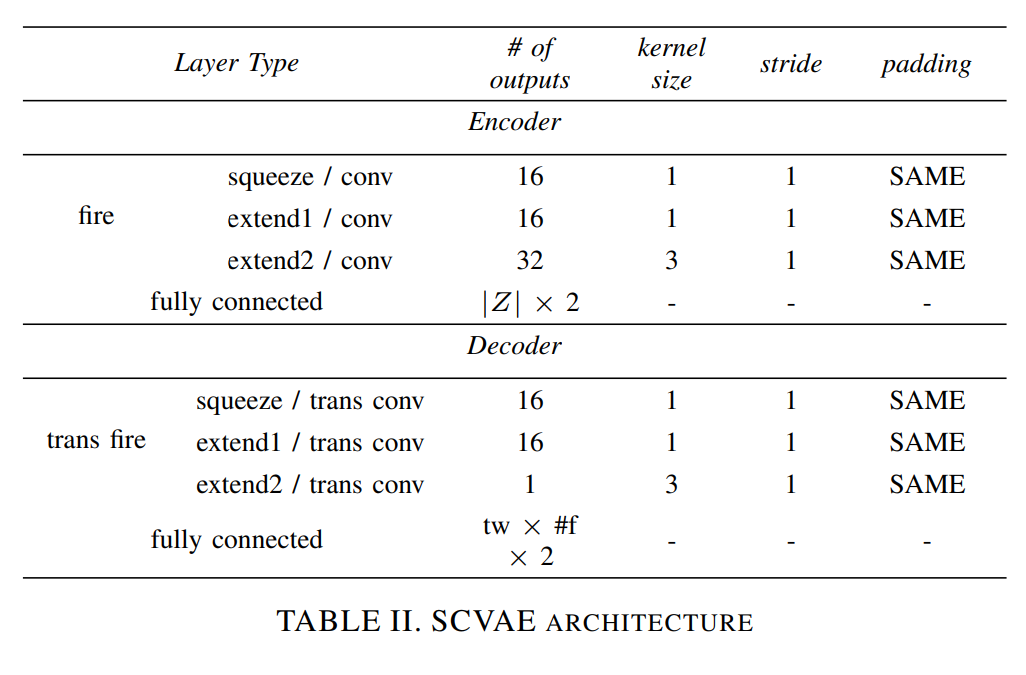

In [17]:
def FireModule(x):    
    x = Convolution1D(16, kernel_size=1, stride=1, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(momentum=0.9)(x)

    extend1 = Convolution1D(16, kernel_size=1, stride=1, padding='same')(x)
    extend1 = Activation('relu')(extend1)
    extend1 = BatchNormalization(momentum=0.9)(extend1)

    extend2 = Convolution2D(32, kernel_size=3, stride=1, padding='same')(x)
    extend2 = Activation('relu')(extend2)
    extend2 = BatchNormalization(momentum=0.9)(extend2)

    x = Concatenate()([extend1, extend1])
    return x

In [ ]:
# dummy layers for now
def build_scvae():
    inputs = keras.Input(shape=(mnist.shape[1],mnist.shape[2],mnist.shape[3]), name="damaged_input")    
    # Encoder transforming image data to "encoder features", or a bottleneck layer
    x = layers.Conv2D(32,4)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    output = layers.Conv2DTranspose(1, 3, activation='tanh')(x)
    autoencoder = keras.Model(inputs, output, name='autoencoder')
    display(autoencoder.summary())
    return autoencoder

In [13]:
pd.read_csv('../datasets/skab/valve1/0.csv',sep=';').drop(columns=['anomaly', 'changepoint']) #unsupervised

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
0,2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0000
1,2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0000
2,2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0000
3,2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0000
4,2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0000
...,...,...,...,...,...,...,...,...,...
1143,2020-03-09 10:34:28,0.026789,0.040617,1.46938,0.054711,75.6738,25.8363,253.533,32.0000
1144,2020-03-09 10:34:29,0.027404,0.041474,1.18285,-0.273216,75.6865,25.8336,205.677,32.0000
1145,2020-03-09 10:34:30,0.026981,0.039410,1.19630,0.054711,75.6305,25.8358,208.907,32.0000
1146,2020-03-09 10:34:31,0.027245,0.040391,1.30745,0.054711,75.7601,25.8363,243.298,32.9986
